In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

In [3]:
import fitsio as fio
import redmapper
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import h5py 
import os.path

# sns.set_theme()
# sns.set_style("ticks")
# sns.set(rc = {'figure.figsize':(12,8)})

/global/homes/z/zchusre/.conda/envs/desdesi/lib/python3.8/site-packages/pyfits/__init__.py:21: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  warnings.warn('PyFITS is deprecated, please use astropy.io.fits',


In [4]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"

In [5]:
lambda_spt_combined_path="data/lambda_spt_combined.pkl"

In [6]:
df = pd.read_pickle(os.path.join(project_path,lambda_spt_combined_path))

$\langle\Sigma \mid \lambda \operatorname{bin}, \zeta \operatorname{bin}\rangle=\int_{\lambda_{\min }}^{\lambda_{\max }} d \lambda \int_{\zeta_{\min }}^{\zeta \max } d \zeta \Sigma P(\Sigma \mid \lambda, \zeta)$

In [7]:
# halo_df = df[(~np.isnan(df['lambda_30']))&(~np.isnan(df['M500c']))]
halo_df = df[(~np.isnan(df['M500c']))]
# halo_df = halo_df[halo_df['zeta_gt_2']==1]
print(len(halo_df))

9341936


In [8]:
mass_mask = halo_df['M500c'] > 1E13
print(np.sum(mass_mask))
halo_df = halo_df[mass_mask]
print(len(halo_df))

699186
699186


To predict it analytically seems difficult.  We could try Monte Carlo first: 

For a given M500c, draw lnλ and lnζ, $\ln M_{WL}$ (using scaling relation and 3x3 covariance matrix)

<lnλ|M> = A + B lnM, scatter

<lnζ|M> = A + B lnM, scatter

<lnMWL|M> = lnM, scatter

Draw with correlated scatter with lnλ (let's assume scatter=0.1, correlation coefficient r)

Bin λ and ζ and calculate the <MWL|det>, <MWL|no det>, <MWL|all>

Repeat, see how these <MWL> changes with r

In [9]:
from colossus.cosmology import cosmology
h = 0.6726
params = {'flat' : True, 'H0' : 67.26,  'Om0' : 0.14212/h**2, 'Ob0' : 0.02222/h**2, 'sigma8' : 0.81, 'ns' : 9.9652, 'w0' : -1.0, 'Neff' : 3.04}
cosmo = cosmology.setCosmology('Abacus',params)
print(cosmo)
h_70 = cosmo.H0/70

Cosmology "Abacus" 
    flat = True, Om0 = 0.3142, Ode0 = 0.6858, Ob0 = 0.0491, H0 = 67.26, sigma8 = 0.8100, ns = 9.9652
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0400, powerlaw = False


$\langle\ln (\lambda) \mid M\rangle=\ln \lambda_{0}+\mathrm{A}_{\lambda} \ln \left(\mathrm{M} / \mathrm{M}_{\mathrm{piv}}\right)+\mathrm{B}_{\lambda} \ln ((1+\mathrm{z}) / 1.45)$

In [17]:
A_lambda = 0.939
B_lambda = 0.32
ln_lambda_0 = 4.25
sigma_ln_lambda_intrinsic = 0.3
M_piv = 5E14

A_SZ = 5.24
B_SZ = 1.534
C_SZ = 0.465
sigma_ln_sz= 0.161
gamma_f = 1.2
SPT_xi_cut = 4.5

sigma_ln_M_wl = 0.1


#lambda relations 
def get_mean_ln_lambda(M,z,A_lambda_,B_lambda_,ln_lambda_0_):
    return(ln_lambda_0_+A_lambda_*np.log(M*h/M_piv)+B_lambda_*np.log((1+z)/1.45))

def get_sigma_ln_lambda(sigma_ln_lambda_intrinsic_,mean_ln_lambda_):
    # return(np.sqrt(sig_intrinsic**2 + (np.exp(mean_lambda_)-1)/np.exp(2*mean_lambda_)))
    return(np.sqrt(sigma_ln_lambda_intrinsic_**2))

#M_wl relations
def get_mean_ln_M_wl(M500c):
    return(np.log(M500c))

#zeta relations 
def get_mean_ln_zeta(M500c, z, A_SZ_,B_SZ_,C_SZ_):
    ln_zeta = np.log(A_SZ_) + B_SZ_*np.log((M500c*h_70)/(4.3E14)) + C_SZ_*np.log(cosmo.Ez(z)/cosmo.Ez(0.6))
    return ln_zeta

# What should the lognormal parameters be if we use a simple lognormal distribution of zeta?

<AxesSubplot:>

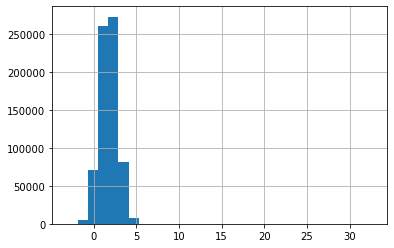

In [18]:
halo_df['xi'].hist(bins=30)

<AxesSubplot:>

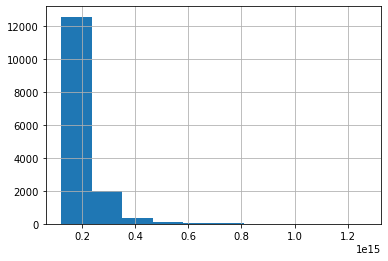

In [19]:
mass_mask = (halo_df['M500c'] >= 1E14) & (halo_df['M500c'] >= 1.2E14)
halo_df[mass_mask]['M500c'].hist()

In [20]:
from scipy.stats import multivariate_normal
M500c_array = halo_df['M500c'].to_numpy()
z_array = halo_df['z'].to_numpy()

In [32]:
def get_cov_matrix(M500c,z,r_):
    mean_ln_lambda = get_mean_ln_lambda(M500c, z, A_lambda, B_lambda, ln_lambda_0)
    sigma_ln_lambda = get_sigma_ln_lambda(sigma_ln_lambda_intrinsic, mean_ln_lambda)
    cov_matrix = np.array([
                          [sigma_ln_lambda**2,          r_*sigma_ln_M_wl*sigma_ln_lambda,     0],
                          [r_*sigma_ln_M_wl*sigma_ln_lambda, sigma_ln_M_wl**2,                0],
                          [0,                      0,                  sigma_ln_sz**2]
                          ])
    return(cov_matrix)

In [33]:
test = get_cov_matrix(1E14, 0.3, 1)

In [34]:
print(sigma_ln_sz)
print(sigma_ln_M_wl)

0.161
0.1


(array([1.25766e+05, 1.15989e+05, 1.15280e+05, 1.21535e+05, 9.29390e+04,
        5.16890e+04, 2.41110e+04, 1.62810e+04, 1.11480e+04, 7.85200e+03,
        5.42800e+03, 5.07700e+03, 3.51500e+03, 1.59500e+03, 5.78000e+02,
        2.43000e+02, 9.50000e+01, 4.40000e+01, 1.20000e+01, 9.00000e+00]),
 array([13.001052 , 13.106164 , 13.211275 , 13.316387 , 13.421499 ,
        13.526611 , 13.631723 , 13.736835 , 13.841947 , 13.947059 ,
        14.05217  , 14.157282 , 14.262394 , 14.367506 , 14.472618 ,
        14.577729 , 14.682841 , 14.787953 , 14.8930645, 14.998177 ,
        15.103289 ], dtype=float32),
 <BarContainer object of 20 artists>)

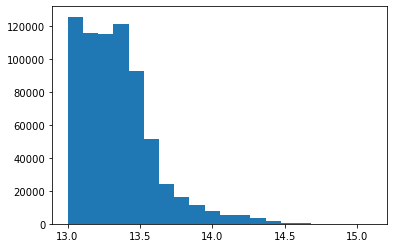

In [35]:
plt.hist(np.log10(halo_df['M500c']),bins=20)

In [39]:
def get_mean(M500c,z):
    mean_ln_lambda = get_mean_ln_lambda(M500c, z, A_lambda, B_lambda, ln_lambda_0)
    mean_ln_M_wl = get_mean_ln_M_wl(M500c)
    mean_ln_zeta = get_mean_ln_zeta(M500c, z, A_SZ, B_SZ, C_SZ)
    return(mean_ln_lambda, mean_ln_M_wl, mean_ln_zeta)

Text(0.5, 1.0, 'Richness d=30')

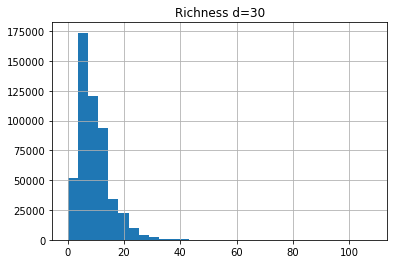

In [40]:
halo_df['lambda_30'].hist(bins=30)
plt.title("Richness d=30")

Text(0.5, 1.0, 'Histogram of richness')

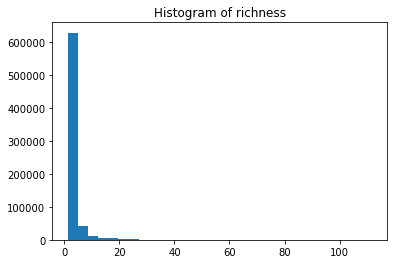

In [41]:
test = get_mean(M500c_array,0.3) #MC mean
plt.hist(np.exp(test[0]),bins=30)
plt.title("Histogram of richness")

(array([8.5730e+04, 8.0229e+04, 7.5796e+04, 7.5774e+04, 8.0407e+04,
        8.0634e+04, 6.6284e+04, 4.8580e+04, 2.9764e+04, 1.7304e+04,
        1.2807e+04, 1.0281e+04, 7.8070e+03, 6.2800e+03, 4.9130e+03,
        3.6920e+03, 3.4790e+03, 3.3340e+03, 2.6080e+03, 1.6040e+03,
        8.9800e+02, 4.3600e+02, 2.5700e+02, 1.2800e+02, 7.3000e+01,
        3.3000e+01, 3.3000e+01, 9.0000e+00, 5.0000e+00, 7.0000e+00]),
 array([13.001052 , 13.071127 , 13.141201 , 13.211275 , 13.28135  ,
        13.351425 , 13.421499 , 13.491573 , 13.561648 , 13.631723 ,
        13.7017975, 13.771872 , 13.841947 , 13.912022 , 13.982096 ,
        14.05217  , 14.122245 , 14.19232  , 14.262394 , 14.332468 ,
        14.402543 , 14.472618 , 14.542692 , 14.612766 , 14.682841 ,
        14.752916 , 14.82299  , 14.8930645, 14.96314  , 15.033215 ,
        15.103289 ], dtype=float32),
 <BarContainer object of 30 artists>)

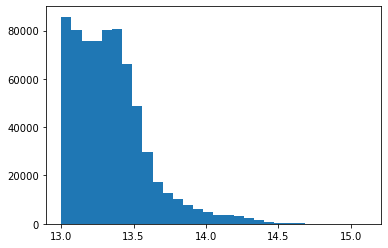

In [42]:
#Mass histogram from the halo catalog
plt.hist(np.log10(M500c_array),bins=30)

In [43]:
def get_MC_for_r(halo_df, r):
    richness_array = np.empty(len(halo_df))
    M_wl_array = np.empty(len(halo_df))
    zeta_array = np.empty(len(halo_df))
    
    for i in range(len(halo_df)):   
        
        covariance = get_cov_matrix(M500c_array[i], z_array[i],r)
        # print(covariance)
        
        ln_richness, ln_M_wl, ln_zeta = multivariate_normal.rvs(mean=get_mean(M500c_array[i],z_array[i]),
                                    cov=covariance)
        
        richness_array[i] = np.exp(ln_richness)
        M_wl_array[i] = np.exp(ln_M_wl)
        zeta_array[i] = np.exp(ln_zeta)

    halo_df[f'MC_richness_{r}'] = richness_array
    halo_df[f'MC_M_wl_{r}'] = M_wl_array
    halo_df[f'MC_zeta_{r}'] = zeta_array

In [67]:
# richness_bins = [0,20,30,45,60,np.inf]
lnlam_bins = np.linspace(np.log(20), np.log(100), 10)
richness_bins=np.exp(lnlam_bins)

In [68]:
r_bins = np.linspace(0,1,5)
# r_bins = [1]
# r_bins = np.array([0,1])
# print(r_bins)
for r in r_bins:
    get_MC_for_r(halo_df, r)
    halo_df[f'MC_richness_bin_{r}'], richness_cats  = pd.cut(halo_df[f'MC_richness_{r}'],richness_bins,
                                                   retbins=True)

In [69]:
halo_df.columns

Index(['R_lambda_60', 'lambda_60', 'R_lambda_30_noperc', 'lambda_30_noperc',
       'R_lambda_30', 'lambda_30', 'R_lambda_15', 'lambda_15', 'R_lambda_1',
       'lambda_1', 'parent_id', 'M500c', 'M200b', 'z', 'pos_x', 'pos_y',
       'pos_z', 'mean_ln_zeta', 'mean_ln_lambda', 'zeta', 'xi', 'xi_gt_45',
       'xi_gt_5', 'zeta_gt_2', 'select', 'MC_richness_0.0', 'MC_M_wl_0.0',
       'MC_zeta_0.0', 'MC_richness_bin_0.0', 'MC_richness_0.25',
       'MC_M_wl_0.25', 'MC_zeta_0.25', 'MC_richness_bin_0.25',
       'MC_richness_0.5', 'MC_M_wl_0.5', 'MC_zeta_0.5', 'MC_richness_bin_0.5',
       'MC_richness_0.75', 'MC_M_wl_0.75', 'MC_zeta_0.75',
       'MC_richness_bin_0.75', 'MC_richness_1.0', 'MC_M_wl_1.0', 'MC_zeta_1.0',
       'MC_richness_bin_1.0', 'MC_M_bin'],
      dtype='object')

In [47]:
sns.set_style('ticks')

In [70]:
len(halo_df)

699186

In [73]:
len(richness_bins)

10

[0.75323586 0.64977005 0.65079885 0.56608246 0.47007954 0.47793831
 0.49650517 0.62619878 0.48621569]
----------------------------------------------------------------
[0.74771714 0.58630983 0.5182994  0.51865626 0.42487577 0.49183216
 0.45707062 0.86383699 0.68089305]
----------------------------------------------------------------
[0.54194593 0.55831199 0.52680005 0.42041184 0.44792755 0.42983159
 0.42143456 0.38696101        nan]
----------------------------------------------------------------
[0.61863213 0.5161799  0.47500998 0.41703032 0.38061775 0.36557735
 0.45765267 0.47531896        nan]
----------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.49317884 0.47719934 0.42551405 0.3738808  0.35397274 0.37018545
 0.4240058  0.35100818 0.42640513]
----------------------------------------------------------------


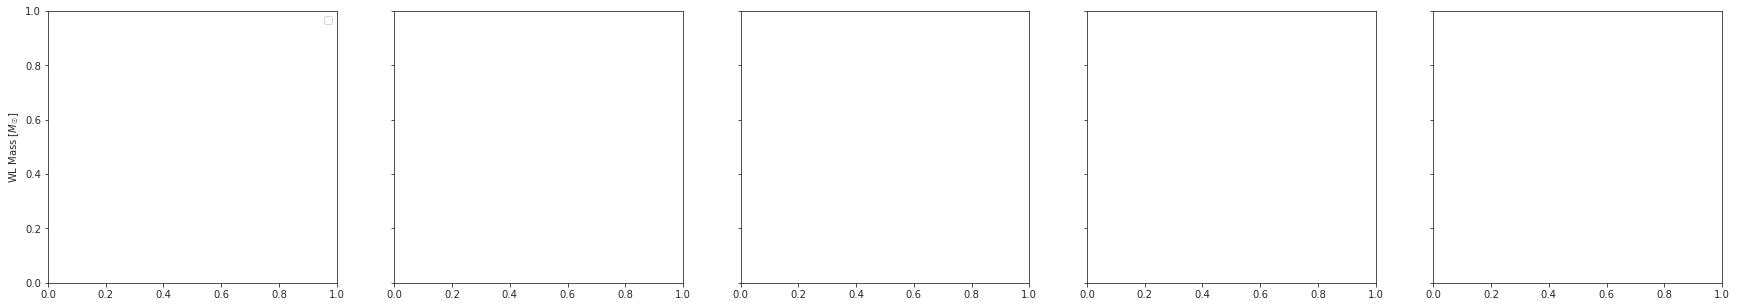

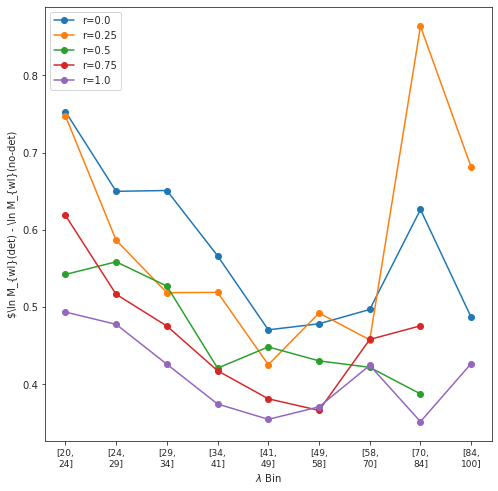

In [84]:
fig, axes = plt.subplots(ncols=5,figsize=[30,5],sharey=True)

fig_ratio, ax_ratio = plt.subplots(figsize=[8,8])

n_richness_bins = len(richness_bins)-1


def plot_M_wl(ax, M_wl_det, M_wl_no_det, M_wl_all, r):
    ax.plot(range(5),M_wl_det,label="det")
    ax.plot(range(5),M_wl_no_det,label="no_det")
    ax.plot(range(5),M_wl_all,label="all")
    locs, labels = plt.xticks()
    xticks = (np.arange(0,5,5), ["1"])
    ax.set_xticks(range(5))
    ax.set_xticklabels([f"[{richness_bins[i]:3},\n{richness_bins[i+1]:3}]" for i in range(n_richness_bins)])
    ax.text(0.5, 0.95, rf'r={r}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.tick_params(axis='x', labelsize=9)
    
def plot_M_wl_ratio(ax, M_wl_det, M_wl_no_det, r):
    print(np.log(M_wl_det.to_numpy())-np.log(M_wl_no_det.to_numpy()))
    locs, labels = plt.xticks()
    ax.set_xticks(range(n_richness_bins))
    ax.plot(range(n_richness_bins), np.log(M_wl_det.to_numpy())-np.log(M_wl_no_det.to_numpy()), 'o-', label=f"r={r}")
    ax.set_xticklabels([f"[{round(richness_bins[i])},\n{round(richness_bins[i+1])}]" for i in range(n_richness_bins)])
    ax.set_xlabel(r"$\lambda$ Bin")
    ax.set_ylabel(r"$\ln M_{wl}(det) - \ln M_{wl}(no-det)")
    ax.tick_params(axis='x', labelsize=9)

verbose = False 

for i,r in enumerate(r_bins):
    # SPT selection line here 
    SPT_mask = halo_df[f'MC_zeta_{r}'] >= 4
    # SPT_mask = halo_df['select'] == 1
    
    M_wl_det = halo_df[SPT_mask].groupby(halo_df[SPT_mask][f'MC_richness_bin_{r}']).mean()[f'MC_M_wl_{r}']
    M_wl_no_det = halo_df[~SPT_mask].groupby(halo_df[~SPT_mask][f'MC_richness_bin_{r}']).mean()[f'MC_M_wl_{r}']
    M_wl_all = halo_df.groupby(halo_df[f'MC_richness_bin_{r}']).mean()[f'MC_M_wl_{r}']
    
    # plot_M_wl(axes[i],M_wl_det, M_wl_no_det, M_wl_all, r)
    
    plot_M_wl_ratio(ax_ratio, M_wl_det, M_wl_no_det, r)
    
    #print halos counts 
    
    if verbose is True:
    
        print("Correlation coefficient is:", r)
        print("Number of det, no_det, all:", len(halo_df[SPT_mask]), len(halo_df[~SPT_mask]), len(halo_df))

        print("Count for SPT Detect")
        print(halo_df[SPT_mask].groupby(halo_df[SPT_mask][f'MC_richness_bin_{r}']).count()['zeta'])
        print("\n")
        print("Count for non-SPT Detect")
        print(halo_df[~SPT_mask].groupby(halo_df[~SPT_mask][f'MC_richness_bin_{r}']).count()['zeta'])
        print("\n")
        print("Count for All")
        print(halo_df.groupby(halo_df[f'MC_richness_bin_{r}']).count()['zeta'])
        print("----------------------------------------------------------------")
    
    #print correlations within each richness bin given r
        for richness in np.unique(pd.cut(halo_df[f'MC_richness_{r}'],richness_bins)):
            print(f"Curretn r {r}")
            print(f"Current richess bin: {richness}")
            richness_mask = halo_df[f'MC_richness_bin_{r}'] == richness
            print(halo_df[richness_mask][[f'MC_richness_{r}', f'MC_M_wl_{r}', 'zeta', 'M500c']].corr())
    
    print("----------------------------------------------------------------")
    
plt.subplots_adjust(wspace=0)
# plt.yscale('log')
axes[0].set_ylabel(u"WL Mass [$M_\u2609$]")
axes[0].legend()

ax_ratio.legend()

In [52]:
# 0.1 dex mass bins 
# 1 bin for 1E15 
# change richness bins

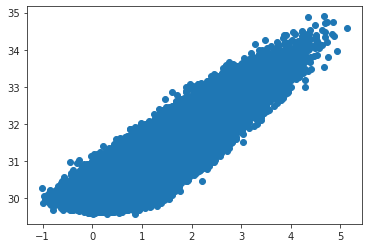

In [53]:
plt.scatter(np.log(halo_df[f'MC_richness_0.0']),np.log(halo_df[f'MC_M_wl_0.0']))

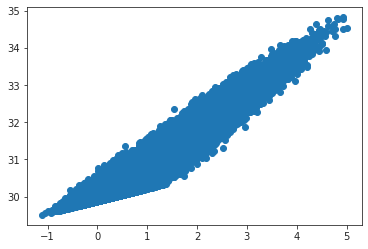

In [54]:
plt.scatter(np.log(halo_df[f'MC_richness_1.0']),np.log(halo_df[f'MC_M_wl_1.0']))

In [55]:
for r in r_bins:
    
    print(halo_df[[f'MC_richness_{r}', f'MC_M_wl_{r}', 'zeta', 'M500c']].corr())
    print("\n")

                 MC_richness_0.0  MC_M_wl_0.0      zeta     M500c
MC_richness_0.0         1.000000     0.906553  0.830557  0.915761
MC_M_wl_0.0             0.906553     1.000000  0.911454  0.990914
zeta                    0.830557     0.911454  1.000000  0.918773
M500c                   0.915761     0.990914  0.918773  1.000000


                  MC_richness_0.25  MC_M_wl_0.25      zeta     M500c
MC_richness_0.25          1.000000      0.920570  0.830095  0.915381
MC_M_wl_0.25              0.920570      1.000000  0.908146  0.990834
zeta                      0.830095      0.908146  1.000000  0.918773
M500c                     0.915381      0.990834  0.918773  1.000000


                 MC_richness_0.5  MC_M_wl_0.5      zeta     M500c
MC_richness_0.5         1.000000     0.932884  0.827240  0.914844
MC_M_wl_0.5             0.932884     1.000000  0.910348  0.991012
zeta                    0.827240     0.910348  1.000000  0.918773
M500c                   0.914844     0.991012  0.918773  

In [56]:
M_bins = np.linspace(halo_df['M500c'].min(),halo_df['M500c'].max(),10)

In [57]:
halo_df[f'MC_M_bin']  = pd.cut(halo_df[f'M500c'],M_bins)

In [58]:
halo_df.groupby('MC_M_bin')